In [46]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from category_encoders import TargetEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [ ]:
# Definindo estilo
sb.set_style("darkgrid")

## Verificando informações do dataset

In [16]:
data.head().style.background_gradient(cmap = 'viridis')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.250000,nan,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.000000,1,0,PC 17599,71.283300,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.925000,nan,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.100000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.050000,nan,S


In [15]:
data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [18]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Análisando features

In [21]:
data.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [20]:
data.Sex.value_counts() / data.shape[0] * 100

male      64.758698
female    35.241302
Name: Sex, dtype: float64

In [23]:
data.loc[data.Sex == 'female', 'Survived'].value_counts() / data.shape[0] * 100

1    26.150393
0     9.090909
Name: Survived, dtype: float64

In [24]:
data.loc[data.Sex == 'male', 'Survived'].value_counts() / data.shape[0] * 100

0    52.525253
1    12.233446
Name: Survived, dtype: float64

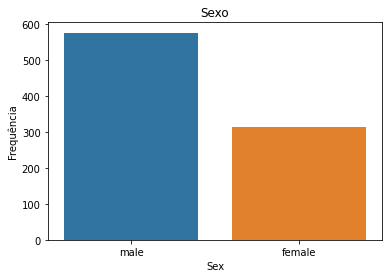

In [36]:
sb.countplot(data.Sex).set_title('Sexo')
plt.xlabel('Sex')
plt.ylabel('Frequência')
plt.show()

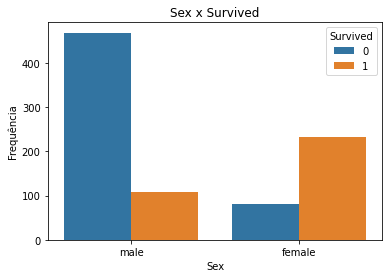

In [35]:
sb.countplot(data.Sex, hue = data.Survived).set_title('Sex x Survived')
plt.xlabel('Sex')
plt.ylabel('Frequência')
plt.show()

In [27]:
data.Pclass.value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [28]:
data.Pclass.value_counts() / data.shape[0] * 100

3    55.106622
1    24.242424
2    20.650954
Name: Pclass, dtype: float64

In [29]:
data.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [30]:
data.Embarked.value_counts() / data.shape[0] * 100

S    72.278339
C    18.855219
Q     8.641975
Name: Embarked, dtype: float64

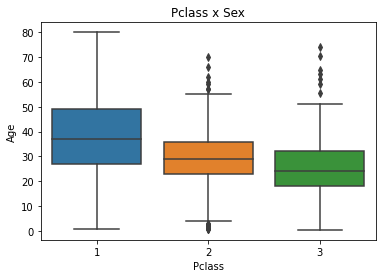

In [34]:
sb.boxplot(x = data.Pclass, y = data.Age).set_title('Pclass x Sex')
plt.show()

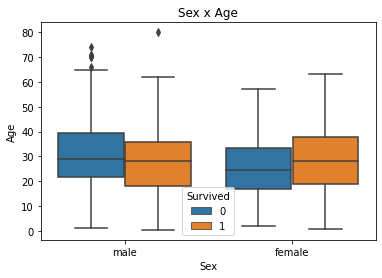

In [37]:
sb.boxplot(x = data.Sex, y = data.Age, hue = data.Survived).set_title('Sex x Age')
plt.xlabel('Sex')
plt.ylabel('Age')
plt.show()

## Realisando tratamento dos dados

In [38]:
# Retirando dados não relevantes
data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1, inplace = True)
test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1, inplace = True)

In [39]:
# Verificando valores nulos
data.isnull().sum().sort_values(ascending = True)

Survived      0
Pclass        0
Sex           0
SibSp         0
Parch         0
Fare          0
Embarked      2
Age         177
dtype: int64

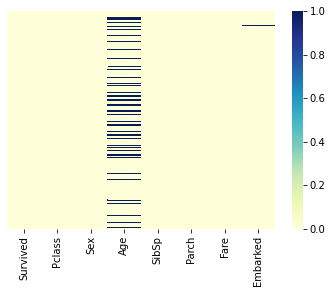

In [40]:
sb.heatmap(data.isnull(), cmap = "YlGnBu", yticklabels = False)

In [41]:
# Tratando valores nulos
data.Embarked.describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [42]:
data.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [43]:
data['Embarked'].fillna('S', inplace = True)

In [44]:
dados = [data]

for dataset in dados:
    mean = data["Age"].mean()
    std = data["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    # Compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # Fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = data["Age"].astype(int)

## Categorical encoding

In [ ]:
# Label Encoding
data['Sex'] = data['Sex'].map({'male': 0, 'female': 1})
data['Embarked'] = data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

In [ ]:
# One-Hot Encoding
data = pd.get_dummies(data)
test = pd.get_dummies(test)

In [ ]:
# Target Encoder
encoder = TargetEncoder()
data['NewEmbarked'] = encoder.fit_transform(data['Embarked'], data['Survived'])

encoder1 = TargetEncoder()
data['NewSex'] = encoder1.fit_transform(data['Sex'], data['Survived'])

data.drop(['Embarked', 'Sex'], axis = 1, inplace = True)

## Tratando dados de trino, teste


In [ ]:
# Separando features e target
preditos = data.drop('Survived', axis = 1)
classe = data.iloc[:, 0].values

# Dividindo base entre treino e teste
X_training, X_test, y_training, y_test = train_test_split(preditos, classe, test_size = 0.3, random_state = 0)

## Modelos

In [ ]:
# Criando modelo Gradient Boostingde
modelo1 = GradientBoostingClassifier()
modelo1.fit(X_training, y_training)

### Gradient Boostingde

In [ ]:
# Testando modelo
previsoes1 = modelo1.predict(X_test)

In [ ]:
# Gerando matriz de confusão
confusao1 = confusion_matrix(y_test, previsoes1)

In [ ]:
# Verificando taxa de acerto
taxa_acerto1 = round(accuracy_score(y_test, previsoes1) * 100, 2)

In [ ]:
modelo1.score(X_training, y_training)

In [ ]:
print(classification_report(y_test, previsoes1))

In [ ]:
# Criando modelo Decision Tree
modelo2 = DecisionTreeClassifier()
modelo2.fit(X_training, y_training)

### Decision Tree

In [ ]:
# Testando modelo
previsoes2 = modelo2.predict(X_test)

In [ ]:
# Verificando taxa de acerto e erro
taxa_acerto2 = round(accuracy_score(y_test, previsoes2) * 100, 2)

In [ ]:
modelo2.score(X_training, y_training)

In [ ]:
print(classification_report(y_test, previsoes2))

In [ ]:
# Criando modelo Random Forest
modelo3 = RandomForestClassifier(n_estimators = 120)
modelo3.fit(X_training, y_training)

### Random Forest

In [ ]:
# Testando modelo
previsoes3 = modelo3.predict(X_test)

In [ ]:
# Verificando taxa de acerto e erro
taxa_acerto3 = round(accuracy_score(y_test, previsoes3) * 100, 2)

In [ ]:
modelo3.score(X_training, y_training)

In [ ]:
print(classification_report(y_test, previsoes3))

In [ ]:
# Gerando arquivo para envio Kaggle
submission = pd.DataFrame()
submission['PassengerId'] = new_test['PassengerId']
submission['Survived'] = modelo.predict(new_test)
submission.to_csv('submission.csv', index = False)

## Submission